Visualizing the 3D geometry of the X-ray detector in `DiffDRR` can be a helpful sanity check and is useful for debugging. We enable visualization of the `DiffDRR` setup using `PyVista`. The dependencies are `pyvista`, `trame`, and `vtk`.

The 3D visualization functions in `DiffDRR` perform the following steps:

- Extract a mesh from your CT volume
- Plot a pyramid frustum to visualize the camera pose
- Plot the detector plane with the DRR embedded as a texture
- Draw the principal ray from the X-ray source to the detector plane

We currently support the following backends for extracting meshes from CT scans:

- [MarchingCubes](https://docs.pyvista.org/version/stable/examples/01-filter/flying_edges.html#marching-cubes)
- [SurfaceNets](https://www.kitware.com/really-fast-isocontouring/)

As of `DiffDRR v0.4.0`, we also support the rendering of 3D labelmaps (e.g., segmentations of CT scans with [TotalSegmentator](https://github.com/wasserth/TotalSegmentator)).

In [ ]:
#| code-fold: true
import matplotlib.pyplot as plt
import pyvista
import torch

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.pose import convert
from diffdrr.visualization import drr_to_mesh, img_to_mesh, labelmap_to_mesh, plot_drr

pyvista.start_xvfb()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Read in the CT volume
subject = load_example_ct()

# Make a mesh from the CT volume
ct = drr_to_mesh(subject, "surface_nets", threshold=225, verbose=True)

Performing Labeled Surface Extraction: 100%|██████████████████████████████████████████████████████[00:00<00:00]
Finding and Labeling Connected Regions.: 100%|████████████████████████████████████████████████████[00:00<00:00]
Smoothing Mesh using Taubin Smoothing: 100%|██████████████████████████████████████████████████████[00:01<00:00]
Filling Holes: 100%|██████████████████████████████████████████████████████████████████████████████[00:00<00:00]
Cleaning: 100%|███████████████████████████████████████████████████████████████████████████████████[00:00<00:00]


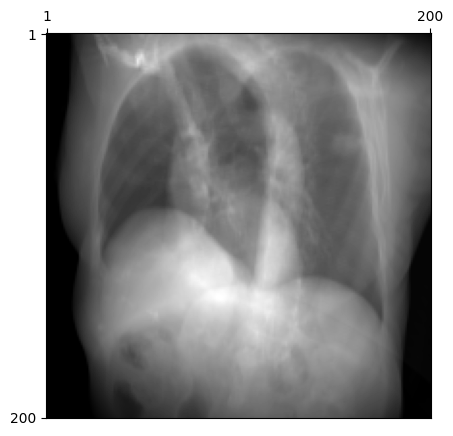

In [ ]:
# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = DRR(subject, sdd=1020.0, height=200, delx=2.0).to(device)

# Make a pose
zero = torch.tensor([[0.0, 0.0, 0.0]], device=device)
xyz = torch.tensor([[0.0, 800.0, 0.0]], device=device)
rot = torch.tensor([[torch.pi / 4, torch.pi / 6, 0.0]], device=device)
pose1 = convert(zero, xyz, parameterization="euler_angles", convention="ZXY")
pose2 = convert(rot, zero, parameterization="euler_angles", convention="ZXY")
pose = pose1.compose(pose2)

plot_drr(drr(pose))
plt.show()

In [ ]:
# Make a mesh from the camera and detector plane
camera, detector, texture, principal_ray = img_to_mesh(drr, pose)

# Make the plot
plotter = pyvista.Plotter()
plotter.add_mesh(ct)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="lime", line_width=3)
plotter.add_mesh(detector, texture=texture)

# Render the plot
plotter.add_axes()
plotter.add_bounding_box()

# plotter.show()  # If running Jupyter locally
# plotter.show(jupyter_backend="server")  # If running Jupyter remotely
plotter.export_html("render.html")

In [ ]:
from IPython.display import IFrame

IFrame("render.html", height=500, width=749)

## Rendering labelmaps

In [ ]:
from matplotlib.colors import ListedColormap

mask = labelmap_to_mesh(drr.subject)
cmap = ListedColormap(['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3'] * 15)

plotter = pyvista.Plotter()
plotter.add_mesh(mask, cmap=cmap)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="lime", line_width=3)
plotter.add_mesh(detector, texture=texture)
plotter.add_axes()
plotter.add_bounding_box()
plotter.remove_scalar_bar()
plotter.export_html("mask.html")

Performing Labeled Surface Extraction: 100%|██████████████████████████████████████████████████████[00:00<00:00]
Smoothing Mesh using Taubin Smoothing: 100%|██████████████████████████████████████████████████████[00:01<00:00]
Cleaning: 100%|███████████████████████████████████████████████████████████████████████████████████[00:00<00:00]


In [ ]:
IFrame("mask.html", height=500, width=749)